## Продвинутые Свёрточные Нейронные Сети. 
### Домашнее задание к уроку 3

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

In [1]:
# %tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета 

In [3]:
%%time
# tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
     split=['train[:80%]', 'train[80%:]'],
)

CPU times: user 199 ms, sys: 12.1 ms, total: 211 ms
Wall time: 244 ms


## Визуализация датасета

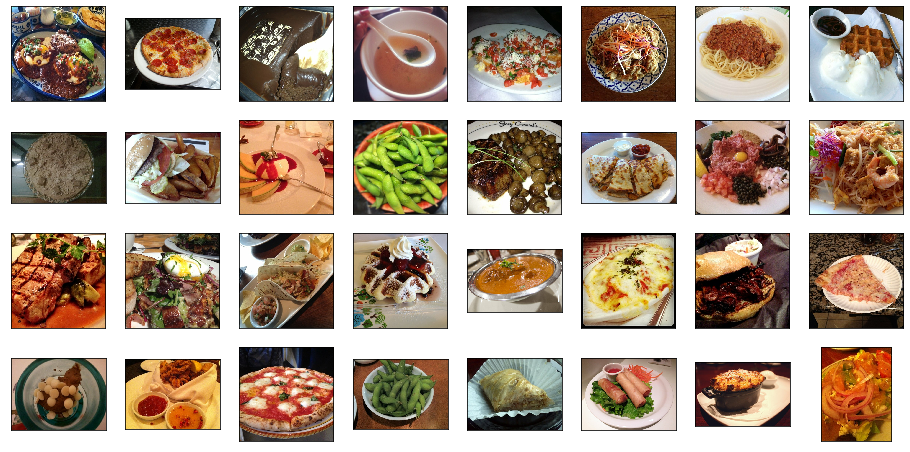

In [4]:
some_samples = [x[0] for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [6]:
# %%time
# some_samples = [x[0] for x in iter(train_ds.take(1))]
# print(some_samples)
# plt.imshow(some_samples)

## Создание пайплайна данных

In [7]:
INP_SIZE = 160
NUM_EPOCHS = 8
BATCH_SIZE = 64

In [8]:
def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

Операции с изображением для аугментации: 
https://www.tensorflow.org/api_docs/python/tf/image?hl=ru#flipping_rotating_and_transposing_2


In [9]:
import random

def augmentation(img, label):
    random.seed(42)
    
    if random.randint(1,2) == 2: 
        img = tf.image.random_flip_left_right(img, seed=42)
    else: 
        img = tf.image.random_flip_up_down(img, seed=42)
    return img, label

In [10]:
train_ds = train_ds.shuffle(buffer_size=2000)
print('train_ds', train_ds)

train_ds = train_ds.map(prepare)
print('prepare', train_ds)

augmentation_ds = train_ds.map(augmentation)
print('augmentation_ds', augmentation_ds)
train_ds = train_ds.concatenate(augmentation_ds)
print('final', train_ds)

train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=2000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

train_ds <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
prepare <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
augmentation_ds <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
final <ConcatenateDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


In [11]:
out = ds_info.features['label']
out

ClassLabel(shape=(), dtype=tf.int64, num_classes=101)

# Подготовка модели CNN

In [12]:
# if 0: # Обучение модели с нуля

#     EXP_NAME = 'scratch'
#     base_model = tf.keras.applications.MobileNetV2(
#         input_shape=(INP_SIZE, INP_SIZE, 3),
#         include_top=False,
#         weights=None,
#     )
#     base_model.trainable = True

# else:
#     # Transfer Learning

EXP_NAME = 'transfer3'
base_model = tf.keras.applications.MobileNetV2(
input_shape=(INP_SIZE, INP_SIZE, 3),
include_top=False,
weights='imagenet',
)
# base_model.trainable = True # Fine-tuning весов предобученной модели
base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
base_model,
    
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(128, activation='softmax'), # добавил слой
# tf.keras.layers.Dropout(0.3),    # добавил дропаут
tf.keras.layers.Dense(out.num_classes, activation='softmax'), # можно установить 'softmax'
])

## Подготовка к обучению

In [13]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE) # можно заменить на adam

model.compile(optimizer=optimizer,
              loss='mean_squared_error',  # заменил loss https://www.tensorflow.org/api_docs/python/tf/keras/losses
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, 
    update_freq=100, 
    profile_batch=0)

## Model Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 101)               13029     
Total params: 2,434,981
Trainable params: 176,997
Non-trainable params: 2,257,984
_________________________________________________________________


## Обучение модели

In [ ]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/8
 295/1893 [===>..........................] - ETA: 37:10 - loss: 3337.1079 - accuracy: 0.0103

## Оценка качества модели

In [ ]:
%%time

model.evaluate(test_ds)

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Запуск предсказания на нашем изображении

In [ ]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

img = imageio.imread('bread.jpeg')

plt.imshow(img)
img = prepare_image(img)

In [ ]:
pred = model(img[None, ...], training=False) #  training=False - отключаем дропауты

pred_label = int(pred.numpy()[0][0] > 0.5)
print('Prediction: {}'.format(ds_info.features['label'].int2str(pred_label)))